In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.1.0


In [22]:
image_width = 256
image_height = 256
batch_size = 16
data_directory = "./data"
train_directory = data_directory + "/train"
test_directory = data_directory + "/test"

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_directory,
                                               color_mode="rgb",
                                               shuffle=True,
                                               target_size=(image_width, image_height),
                                               class_mode='sparse')


image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=test_directory,
                                                 color_mode="rgb",
                                                 target_size=(image_width, image_height),
                                                 class_mode='sparse')

Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


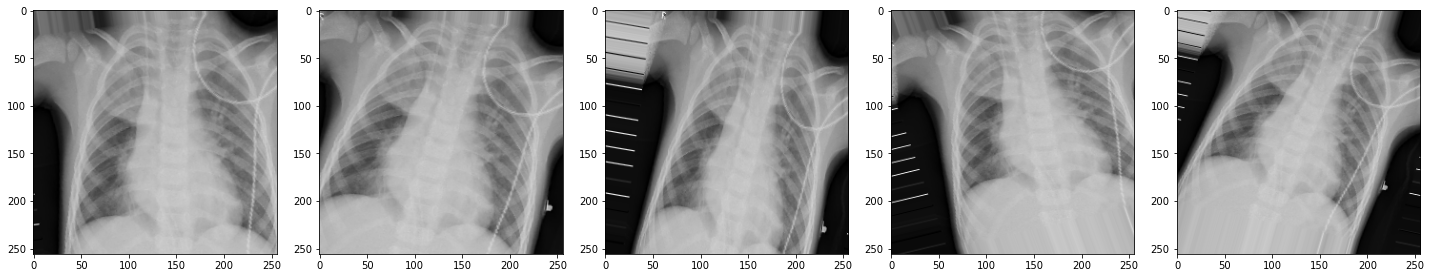

In [18]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [19]:
num_nor_tr = len(os.listdir(train_directory + '/NORMAL'))
num_bac_tr = len(os.listdir(train_directory + '/BACTERIA'))
num_vir_tr = len(os.listdir(train_directory + '/VIRUS'))

num_nor_val = len(os.listdir(test_directory + '/NORMAL'))
num_bac_val = len(os.listdir(test_directory + '/BACTERIA'))
num_vir_val = len(os.listdir(test_directory + '/VIRUS'))

total_train = num_nor_tr + num_bac_tr + num_vir_tr
total_val = num_nor_val + num_bac_val + num_vir_val

total_train, total_val

(5217, 626)

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=train_data_gen.image_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation='softmax')
])
opt = Adam(lr=0.00001)
model.compile(optimizer=opt
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=100
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(batch_size))),
    callbacks=[checkpoint_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 327 steps, validate for 40 steps
Epoch 1/100
 42/327 [==>...........................] - ETA: 19:19 - loss: 0.9680 - accuracy: 0.5717WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 32700 batches). You may need to use the repeat() function when building your dataset.


In [18]:
model.save_weights('model.h5')


model_json = model.to_json()
with open('modelj.json', 'w') as json_file:
    json_file.write(model_json)
    
print('Model saved to the disk.')

Model saved to the disk.
